In [1]:
import sklearn.datasets as skd
categories = ['FS', 'Notes','Junk']
pages_dict = skd.load_files('/Users/baggu/Downloads/FT_ML_training_Data/Input/', categories= categories, encoding= 'ISO-8859-1')

In [2]:
pages_dict.target_names

['FS', 'Junk', 'Notes']

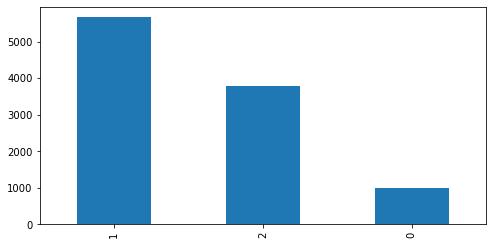

In [3]:
import pandas as pd
target_df = pd.DataFrame(pages_dict.target,columns =['Category'])

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
target_df.Category.value_counts().plot(kind='bar');
plt.show()

In [4]:
# Needed only once
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
import re, unidecode, string
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def remove_numbers(text): 
    result = re.sub(r'\d+', '', text) 
    return result

def remove_slash_with_space(text): 
    return text.replace('\\', " ")

def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator) 

def text_lowercase(text): 
    return text.lower()     

def remove_whitespace(text): 
    return  " ".join(text.split()) 

def remove_stopwords(text): 
    stop_words = set(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return ' '.join(filtered_text)

def stem_words(text): 
    stemmer = PorterStemmer() 
    word_tokens = word_tokenize(text) 
    stems = [stemmer.stem(word) for word in word_tokens] 
    return ' '.join(stems)

def lemmatize_words(text): 
    lemmatizer = WordNetLemmatizer() 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return ' '.join(lemmas) 

In [5]:
# Perform preprocessing
def perform_preprocessing(text):
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = text_lowercase(text)
    text = remove_slash_with_space(text)
    text = remove_punctuation(text)
    text = stem_words(text)
    #text = lemmatize_words(text)
    text = remove_whitespace(text)
    return text

pages_dict.data = list(map(perform_preprocessing, pages_dict.data))

In [6]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(pages_dict['data'], pages_dict['target'], test_size=0.2, random_state=42)

In [7]:
train_pages_dict = {
    'data' : data_train,
    'target' : target_train
}

test_pages_dict = {
    'data' : data_test,
    'target' : target_test
}

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english', min_df=0.03, ngram_range=(1,2)) #I can also specify the range of n-grams
X_train_tf = count_vect.fit_transform(train_pages_dict['data'])
X_train_tf.shape

# # Saving model to disk
# import pickle
# #import requests
# #import json
# pickle.dump(count_vect, open('CountVectorizer.pkl','wb'))
# #0.03 is better than 0.02 & 0.04, 0.05

In [57]:
# # Assigning vectors to the input data
# from sklearn.feature_extraction.text import TFidfVectorizer
# tfidfconverter = TfidfVectorizer(stop_words='english', min_df=0.03, ngram_range=(1,2))
# inputs = tfidfconverter.fit_transform(train_pages_dict['data'])
# inputs.shape

In [9]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer(stop_words='english', min_df=0.02, ngram_range=(1,2)) #I can also specify the range of n-grams
# X_train_tf = count_vect.fit_transform(train_pages_dict['data'])
# X_train_tf.shape

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_train_tfidf.shape

(8372, 963)

AttributeError: get_features not found

In [11]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_tfidf, train_pages_dict['target'])

MultinomialNB()

In [12]:
X_test_tf = count_vect.transform(test_pages_dict['data'])
X_test_tfidf = tfidf_transformer.transform(X_test_tf)
predicted = clf.predict(X_test_tfidf) 

In [13]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
print('Accuracy(Naive Bayes):',accuracy_score(test_pages_dict['target'],predicted))
print(metrics.classification_report(test_pages_dict['target'],predicted,target_names=pages_dict.target_names))
metrics.confusion_matrix(test_pages_dict['target'],predicted)

Accuracy(Naive Bayes): 0.8972766364070712
              precision    recall  f1-score   support

          FS       0.91      0.92      0.91       197
        Junk       0.95      0.88      0.92      1152
       Notes       0.83      0.91      0.87       744

    accuracy                           0.90      2093
   macro avg       0.89      0.91      0.90      2093
weighted avg       0.90      0.90      0.90      2093



array([[ 182,    0,   15],
       [   6, 1018,  128],
       [  13,   53,  678]])

In [35]:
# Saving model to disk
import pickle
#import requests
#import json
pickle.dump(clf, open('nbmodel.pkl','wb'))

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
classifier = RandomForestClassifier(n_estimators=1200, random_state=1)  #defining 1000 nodes 
rf = classifier.fit(X_train_tfidf, train_pages_dict['target'])  

y_pred = classifier.predict(X_test_tfidf) 

from sklearn import metrics
from sklearn.metrics import accuracy_score
print('Accuracy(RF):',accuracy_score(test_pages_dict['target'],y_pred))
print(metrics.classification_report(test_pages_dict['target'],y_pred,target_names=pages_dict.target_names))
metrics.confusion_matrix(test_pages_dict['target'],y_pred)

Accuracy(RF): 0.9541328236980411
              precision    recall  f1-score   support

          FS       0.99      0.95      0.97       197
        Junk       0.96      0.96      0.96      1152
       Notes       0.93      0.94      0.94       744

    accuracy                           0.95      2093
   macro avg       0.96      0.95      0.96      2093
weighted avg       0.95      0.95      0.95      2093



array([[ 188,    3,    6],
       [   0, 1106,   46],
       [   1,   40,  703]])

In [36]:
pickle.dump(rf, open('rfmodel.pkl','wb'))

In [15]:
# import sys
# !{sys.executable} -m pip install xgboost

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_tfidf, train_pages_dict['target'])

y_pred_xgb = xgb.predict(X_test_tfidf)

from sklearn import metrics
from sklearn.metrics import accuracy_score
print('Accuracy(RF):',accuracy_score(test_pages_dict['target'],y_pred_xgb))
print(metrics.classification_report(test_pages_dict['target'],y_pred_xgb,target_names=pages_dict.target_names))
metrics.confusion_matrix(test_pages_dict['target'],y_pred_xgb)


Accuracy(RF): 0.9617773530817009
              precision    recall  f1-score   support

          FS       0.99      0.96      0.97       197
        Junk       0.96      0.97      0.97      1152
       Notes       0.95      0.95      0.95       744

    accuracy                           0.96      2093
   macro avg       0.97      0.96      0.96      2093
weighted avg       0.96      0.96      0.96      2093



array([[ 189,    3,    5],
       [   0, 1120,   32],
       [   2,   38,  704]])

In [37]:
pickle.dump(xgb, open('xgbmodel.pkl','wb'))

In [26]:
## Covert pdf to text file
#!pip install pdfminer
#!pip install io
import io
from io import StringIO
import string
import pandas as pd
import os
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams

def convert_pdf_to_txt(path):
    #alltexts = []
    filelist=os.listdir(path)
    documentcollection=[]
    for files in filelist:
        files=os.path.join(path,files)
        documentcollection.append(files)
    for ifiles in documentcollection:
        if ifiles.endswith('.pdf') or ifiles.endswith('.PDF'): #different extensions on the raw data
            with open(ifiles, 'rb') as fh:
                for page in PDFPage.get_pages(fh, 
                                              caching=True,
                                              check_extractable=True):
                    resource_manager = PDFResourceManager()
                    fake_file_handle = io.StringIO()
                    converter = TextConverter(resource_manager, fake_file_handle)
                    page_interpreter = PDFPageInterpreter(resource_manager, converter)
                    page_interpreter.process_page(page)
 
                    text = fake_file_handle.getvalue() # extraction of the text data
                    yield text
 
                    # closing open handles
                    converter.close()
                    fake_file_handle.close()
        
    #return alltexts

In [38]:
#Loading the saved model and a random PDF file to test classification
savedmodel = pickle.load(open('xgbmodel.pkl','rb'))

In [39]:
filepath='/Users/baggu/Downloads/PDF/'
textcontents = convert_pdf_to_txt(filepath)
dftaxes = pd.DataFrame(textcontents, columns = ['Text_Data'])
##got the text files

In [40]:
### preprocess the data, can also convert to list
dftaxes['Text_Data']

0      2021 2021 ANNUAL REPORT(A joint stock company ...
1      ProfileThe predecessor of the Bank was Agricul...
2      1Annual Report 2021Definitions2Basic Corporate...
3      Definitions2In this report, unless the context...
4      3Annual Report 2021Definitions13.H Share(s)Sha...
                             ...                        
359    358Notes to the Consolidated Financial Stateme...
360    359Annual Report 2021Unaudited Supplementary F...
361    360Unaudited Supplementary Financial Informati...
362                                                    

363    2021 2021 ANNUAL REPORT(A joint stock company ...
Name: Text_Data, Length: 364, dtype: object

In [41]:
dftaxes

,Text_Data
0,2021 2021 ANNUAL REPORT(A joint stock company ...
1,ProfileThe predecessor of the Bank was Agricul...
2,1Annual Report 2021Definitions2Basic Corporate...
3,"Definitions2In this report, unless the context..."
4,3Annual Report 2021Definitions13.H Share(s)Sha...
...,...
359,358Notes to the Consolidated Financial Stateme...
360,359Annual Report 2021Unaudited Supplementary F...
361,360Unaudited Supplementary Financial Informati...
362,


In [42]:
## preprocess the data
dftaxes.Text_Data = dftaxes.Text_Data.apply(perform_preprocessing)

In [54]:
# # Assigning vectors to the input data
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer(stop_words='english', min_df=0.03, ngram_range=(1,2)) #I can also specify the range of n-grams
# inputs_ = count_vect.fit_transform(dftaxes.Text_Data)
# #inputs_.shape
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf_transformer = TfidfTransformer()
# inputs = tfidf_transformer.fit_transform(inputs_)
# inputs.shape

(364, 1065)

In [55]:
### count transform & tfidf transform
### predict
# Predicting the category of the input file with the help of trained model

output_category = savedmodel.predict(inputs)
#Comment the next line if you are testing word2vec model as it doesn't require transformation
#output_category = (labelencoder.inverse_transform((output_category)))
output_category

ValueError: Feature shape mismatch, expected: 963, got 1065

In [44]:
dftaxes

,Text_Data
0,annual report a joint stock compani incorpor p...
1,profileth predecessor bank agricultur cooper b...
2,annual report definitionsbas corpor inform maj...
3,definitionsin report unless context otherwis r...
4,annual report definitionsh share share list th...
...,...
359,note consolid financi statementsfor year end d...
360,annual report unaudit supplementari financi in...
361,unaudit supplementari financi informationfor y...
362,
